### Ways to deploy a machine learning model

We've discussed a couple of options for deploying machine learning models (on-device and cloud).

And each of these will have their specific requirements:

| **Tool/resource** | **Deployment type** | 
| ----- | ----- |
| [Google's ML Kit](https://developers.google.com/ml-kit) | On-device (Android and iOS) | 
| [Apple's Core ML](https://developer.apple.com/documentation/coreml) and [`coremltools` Python package](https://coremltools.readme.io/docs) | On-device (all Apple devices) | 
| [Amazon Web Service's (AWS) Sagemaker](https://aws.amazon.com/sagemaker/) | Cloud | 
| [Google Cloud's Vertex AI](https://cloud.google.com/vertex-ai) | Cloud |
| [Microsoft's Azure Machine Learning](https://azure.microsoft.com/en-au/services/machine-learning/) | Cloud |
| [Hugging Face Spaces](https://huggingface.co/spaces) | Cloud |
| API with [FastAPI](https://fastapi.tiangolo.com) | Cloud/self-hosted server |
| API with [TorchServe](https://pytorch.org/serve/) | Cloud/self-hosted server | 
| [ONNX (Open Neural Network Exchange)](https://onnx.ai/index.html) | Many/general |
| Many more... |

And one of the best ways to do so is by turning your machine learning model into a demo app with [Gradio](https://gradio.app) and then deploying it on Hugging Face Spaces.

We'll be doing just that with FoodVision Mini later on.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/09-tools-and-places-to-deploy-ml-models.png" alt="tools and places to deploy machine learning models" width=900/>

In [38]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, plot_loss_curves
from pathlib import Path
from going_modular.going_modular.predictions import pred_and_plot_image
import random
from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

In [2]:
# set model to MPS if available, or GPU, otherwise default to CPU
if torch.backends.mps.is_available():
    device = "mps"
    print ("MPS device found.")
elif torch.cuda.is_available():
    device = "cuda"
    print("GPU found")
else:
    device = "cpu"
    print ("Neither MPS device nor GPU found.")

# i think since i'm not actually gonna be doing any training i can use mps this time

MPS device found.


In [9]:
# get our best model so far
model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"
# it's a tad bit less accurate than ViT but 10x smaller & therefore faster

In [7]:
def create_effnetB2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    
    for param in model.features.parameters():
        param.requires_grad=False
      
    # replace classifier head for our 3 classes instead of 1000
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=3)
    ).to(device)
    
    model.name = "effnetb2"
    
    return model

In [34]:
effnetb2 = create_effnetB2()

# load saved best model state_dict
effnetb2.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [14]:
# get model size in bytes then convert to megabytes
effnetb2_model_size = Path(model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size}MB.")

EfficientNetB2 feature extractor model size: 29MB.


In [26]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Get EffNetB2 transforms
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()

# create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2821b9590>,
 ['pizza', 'steak', 'sushi'])

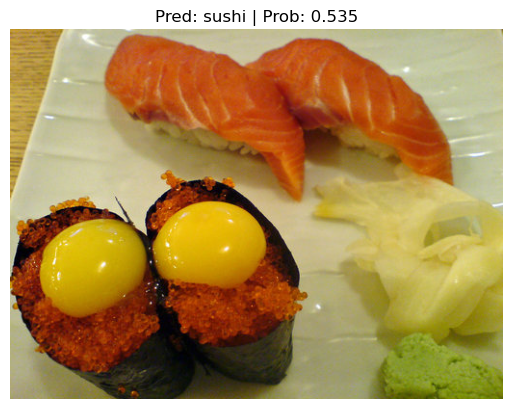

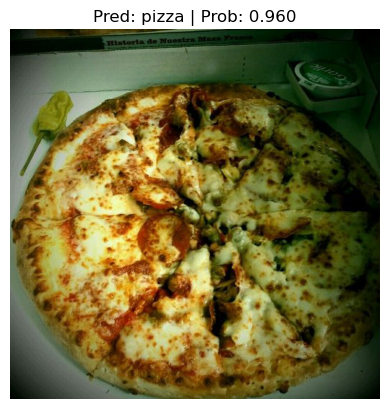

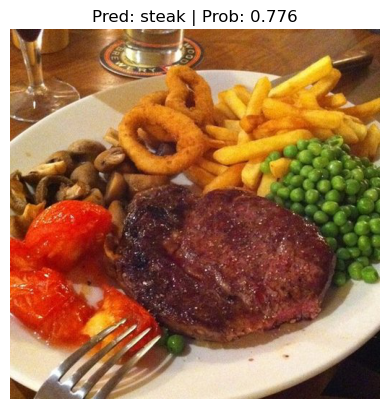

In [35]:
num_images_to_plot = 3
test_image_path_list = list(Path("data/pizza_steak_sushi_20_percent/test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=effnetb2,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

In [36]:
# Print EffNetB2 model summary (uncomment for full output) 
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [30]:
# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi/test


[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg')]

In [33]:
# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths,#: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names,#: List[str], 
                   device: str = "mps" if torch.backends.mps.is_available() else "cpu"):# -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaires
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path)
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list

Let's start by using it to make predictions across the test dataset with our EffNetB2 model, paying attention to two details:

1. **Device** - We'll hard code the `device` parameter to use `"cpu"` because when we deploy our model, we won't always have access to a `"cuda"` (GPU) device.
    * Making the predictions on CPU will be a good indicator of speed of inference too because generally predictions on CPU devices are slower than GPU devices.
2. **Transforms** - We'll also be sure to set the `transform` parameter to `effnetb2_transforms` to make sure the images are opened and transformed in the same way our `effnetb2` model has been trained on. 

In [39]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/75 [00:00<?, ?it/s]

In [40]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.6122,
  'pred_class': 'pizza',
  'time_for_pred': 0.1988,
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8824,
  'pred_class': 'steak',
  'time_for_pred': 0.257,
  'correct': True}]

In [48]:
# get an accuracy rate
correct = 0
incorrect = 0
for test in effnetb2_test_pred_dicts:
    if test['correct']==True:
        correct += 1 
    else:
        incorrect += 1
print(f"{correct / (correct + incorrect) *100}% accuracy")

92.0% accuracy


In [49]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi/test/steak/296375.jpg,steak,0.6122,pizza,0.1988,False
1,data/pizza_steak_sushi/test/steak/673127.jpg,steak,0.8824,steak,0.2570,True
2,data/pizza_steak_sushi/test/steak/894825.jpg,steak,0.8999,steak,0.3148,True
3,data/pizza_steak_sushi/test/steak/1868005.jpg,steak,0.9818,steak,0.3636,True
4,data/pizza_steak_sushi/test/steak/27415.jpg,steak,0.9137,steak,0.3534,True


In [50]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     69
False     6
Name: count, dtype: int64

In [51]:
# Find the average time per prediction 
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.3586 seconds


There are several ways to deploy a machine learning model each with specific use cases (as discussed above).

We're going to be focused on perhaps the quickest and certainly one of the most fun ways to get a model deployed to the internet.

And that's by using [Gradio](https://gradio.app/).

What's Gradio?

The homepage describes it beautifully: 

> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!

In [53]:
import gradio as gr

# actually nvm i don't give a shit about deployment